In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import GridSearchCV
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Explorative Daten Analyse

In [2]:
# Zeitraum für Vergangenheitsdaten (letzte 50 Jahre, falls verfügbar)
start_date = datetime(1980, 1, 1)  # Statt 1940, um Lücken zu vermeiden
end_date = datetime(2024, 3, 1)

# Punkt für Bakersfield, USA
location = Point(35.3733, -119.0187)

# Daten von Meteostat API abrufen
data = Daily(location, start_date, end_date).fetch()

## Summary Statistics:

In [3]:
print(data.describe())

               tavg          tmin          tmax          prcp          snow  \
count  15808.000000  16132.000000  16132.000000  16132.000000  16130.000000   
mean      18.692371     11.926141     25.665485      0.435148      0.004712   
std        7.924751      6.987263      8.914693      2.099032      0.598407   
min      -17.800000     -7.200000      1.100000      0.000000      0.000000   
25%       12.200000      6.100000     18.300000      0.000000      0.000000   
50%       18.000000     11.100000     25.600000      0.000000      0.000000   
75%       25.600000     17.800000     33.300000      0.000000      0.000000   
max       37.200000     30.000000     46.100000     38.900000     76.000000   

              wdir          wspd         wpgt          pres    tsun  
count  6303.000000  16114.000000  5765.000000  15691.000000  1137.0  
mean    236.082024      9.953736    27.918508   1015.376566     0.0  
std     130.245691      3.673261     9.454404      5.222066     0.0  
min     

## Missing values:

In [4]:
print(data.isnull().sum())

tavg      324
tmin        0
tmax        0
prcp        0
snow        2
wdir     9829
wspd       18
wpgt    10367
pres      441
tsun    14995
dtype: int64


## Histogram for each column

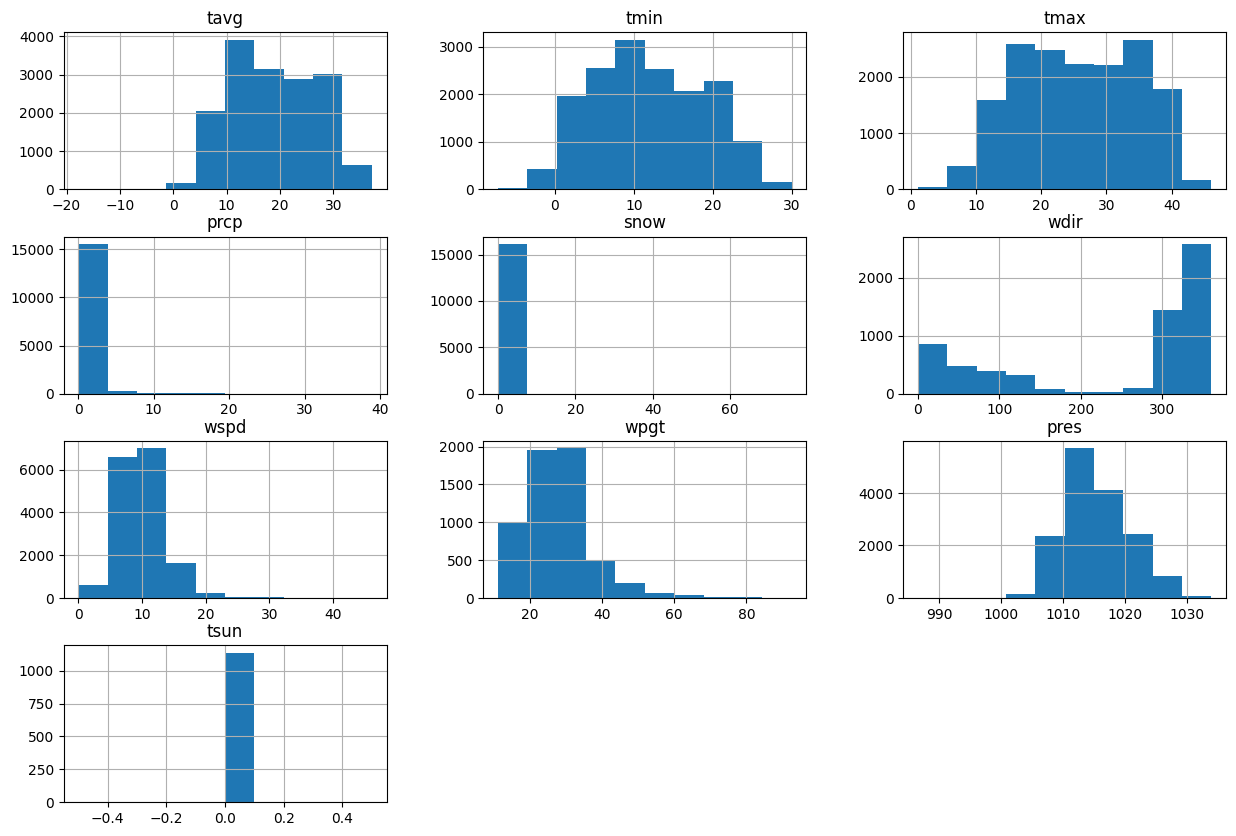

In [5]:
data.hist(figsize=(15, 10))
plt.show()

## Correlation Matrix:

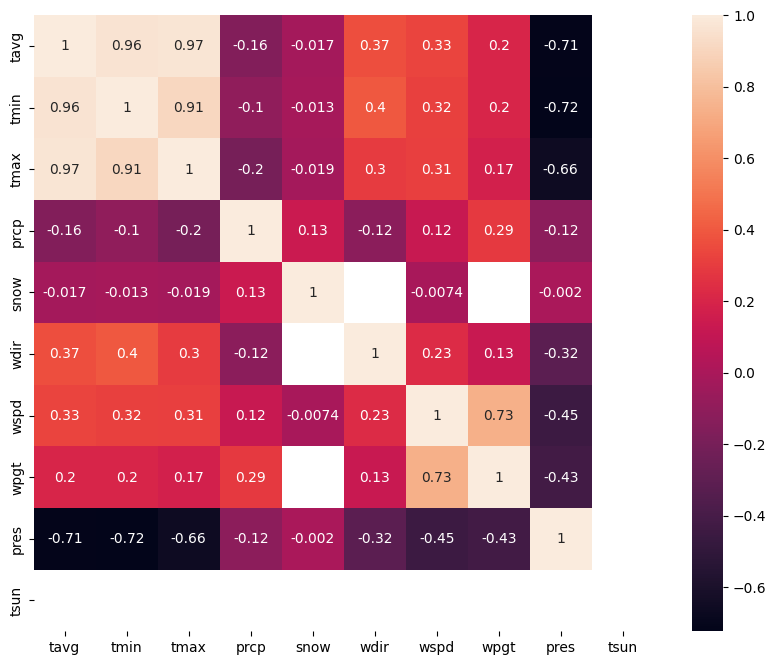

In [6]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Boxplot

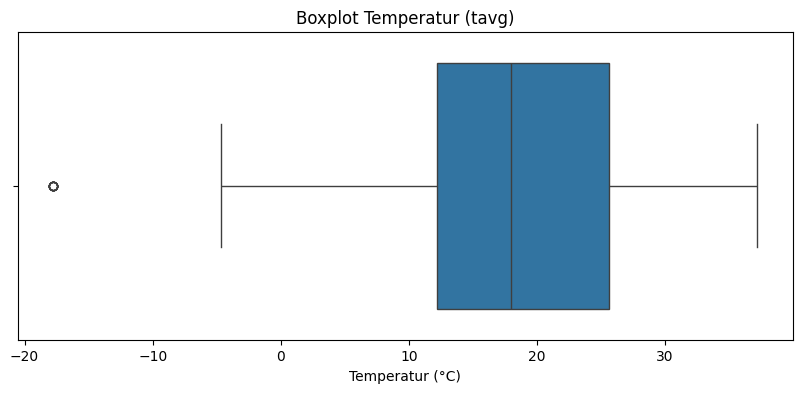

In [7]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['tavg'])
plt.title('Boxplot Temperatur (tavg)')
plt.xlabel('Temperatur (°C)')
plt.show()

Q1 = data['tavg'].quantile(0.25)
Q3 = data['tavg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['tavg'] = data['tavg'].clip(lower=lower_bound, upper=upper_bound)

## Time series for average temperature:

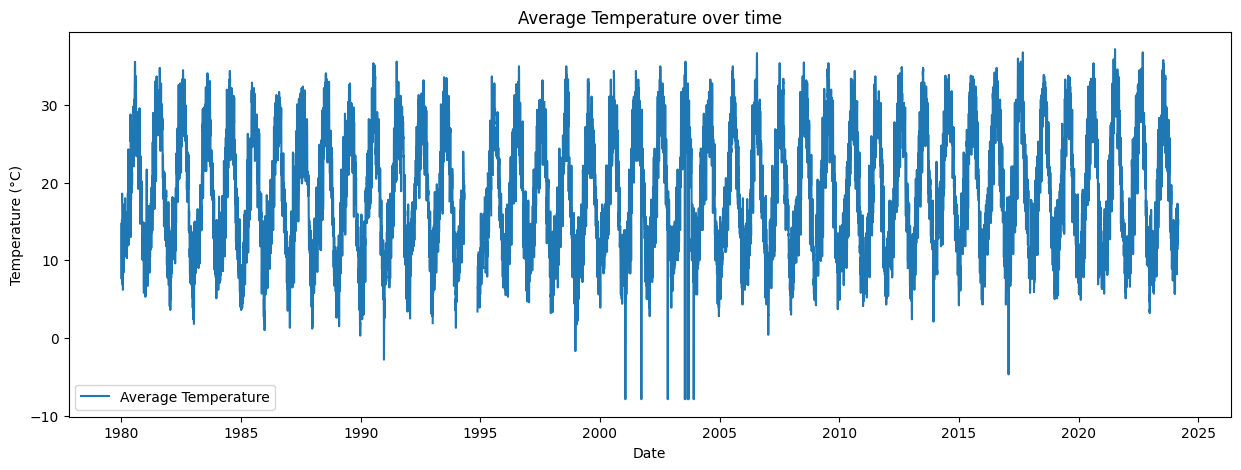

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['tavg'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature over time')
plt.legend()
plt.show()

## Kalman imputation for outliers

Detected bad_periods: [(Timestamp('1981-01-22 00:00:00'), Timestamp('1981-01-22 00:00:00')), (Timestamp('1989-02-05 00:00:00'), Timestamp('1989-02-06 00:00:00')), (Timestamp('1990-12-22 00:00:00'), Timestamp('1990-12-22 00:00:00')), (Timestamp('1990-12-24 00:00:00'), Timestamp('1990-12-24 00:00:00')), (Timestamp('1998-12-22 00:00:00'), Timestamp('1998-12-22 00:00:00')), (Timestamp('2001-01-23 00:00:00'), Timestamp('2001-01-23 00:00:00')), (Timestamp('2001-09-24 00:00:00'), Timestamp('2001-09-24 00:00:00')), (Timestamp('2002-10-31 00:00:00'), Timestamp('2002-11-01 00:00:00')), (Timestamp('2003-07-20 00:00:00'), Timestamp('2003-07-20 00:00:00')), (Timestamp('2003-08-31 00:00:00'), Timestamp('2003-08-31 00:00:00')), (Timestamp('2003-09-14 00:00:00'), Timestamp('2003-09-14 00:00:00')), (Timestamp('2003-12-02 00:00:00'), Timestamp('2003-12-02 00:00:00')), (Timestamp('2004-03-20 00:00:00'), Timestamp('2004-03-20 00:00:00')), (Timestamp('2010-11-05 00:00:00'), Timestamp('2010-11-05 00:00:00')

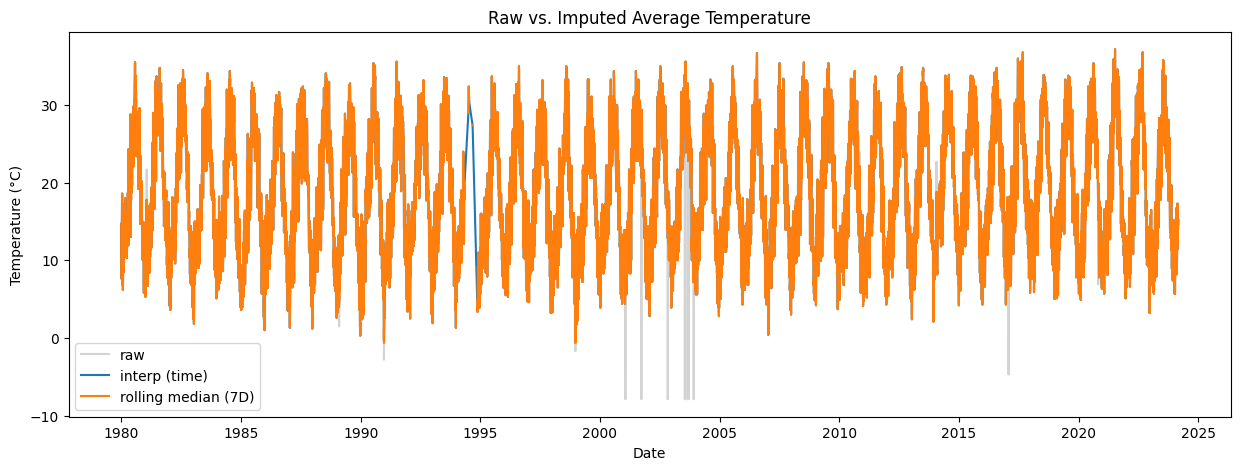

In [9]:
# 1. compute a calendar‐month z-score
monthly_mean = data['tavg'].groupby(data.index.month).transform('mean')
monthly_std  = data['tavg'].groupby(data.index.month).transform('std')
z_scores     = (data['tavg'] - monthly_mean) / monthly_std

# 2. flag >3σ outliers
threshold   = 3.0
is_outlier  = z_scores.abs() > threshold
outlier_dates = data.index[is_outlier]

# 3. group consecutive outlier‐dates into runs
bad_periods = []
if len(outlier_dates) > 0:
    run_start = outlier_dates[0]
    prev_date = outlier_dates[0]
    for curr_date in outlier_dates[1:]:
        if curr_date - prev_date > timedelta(days=1):
            # gap >1 day → end of run
            bad_periods.append((run_start, prev_date))
            run_start = curr_date
        prev_date = curr_date
    # final run
    bad_periods.append((run_start, prev_date))

print("Detected bad_periods:", bad_periods)

# 4. build a mask: outlier AND within one of those runs
mask = pd.Series(False, index=data.index)
idx  = data.index.to_series()
for start, end in bad_periods:
    mask |= is_outlier & idx.between(start, end)

# 5. mask as NaN
data_clean = data.copy()
data_clean.loc[mask, 'tavg'] = np.nan

# 6a. impute by time‐based linear interpolation
data_clean['tavg_interp'] = data_clean['tavg'].interpolate(method='time')

# 6b. alternative: rolling 7‐day median
data_clean['tavg_rollmed'] = (
    data_clean['tavg']
    .fillna(data_clean['tavg']
    .rolling('7D', center=True)
    .median()
    )
)

# 7. compare via plot
plt.figure(figsize=(15,5))
plt.plot(data['tavg'],         color='lightgray', label='raw')
plt.plot(data_clean['tavg_interp'],   label='interp (time)')
plt.plot(data_clean['tavg_rollmed'],  label='rolling median (7D)')
plt.legend()
plt.title("Raw vs. Imputed Average Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [10]:
data['tavg'] = data_clean['tavg_rollmed']

15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing


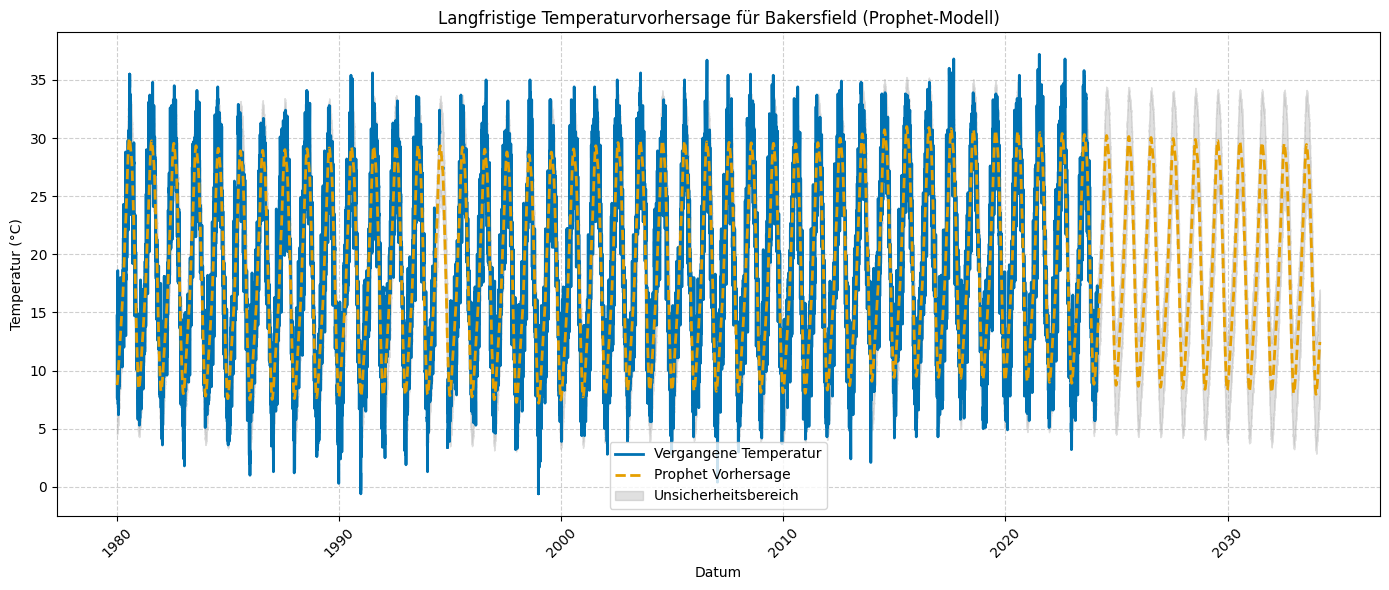

In [11]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
# data['tavg'] = data['tavg'].interpolate(method='time')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=10*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

15:48:04 - cmdstanpy - INFO - Chain [1] start processing
15:48:06 - cmdstanpy - INFO - Chain [1] done processing


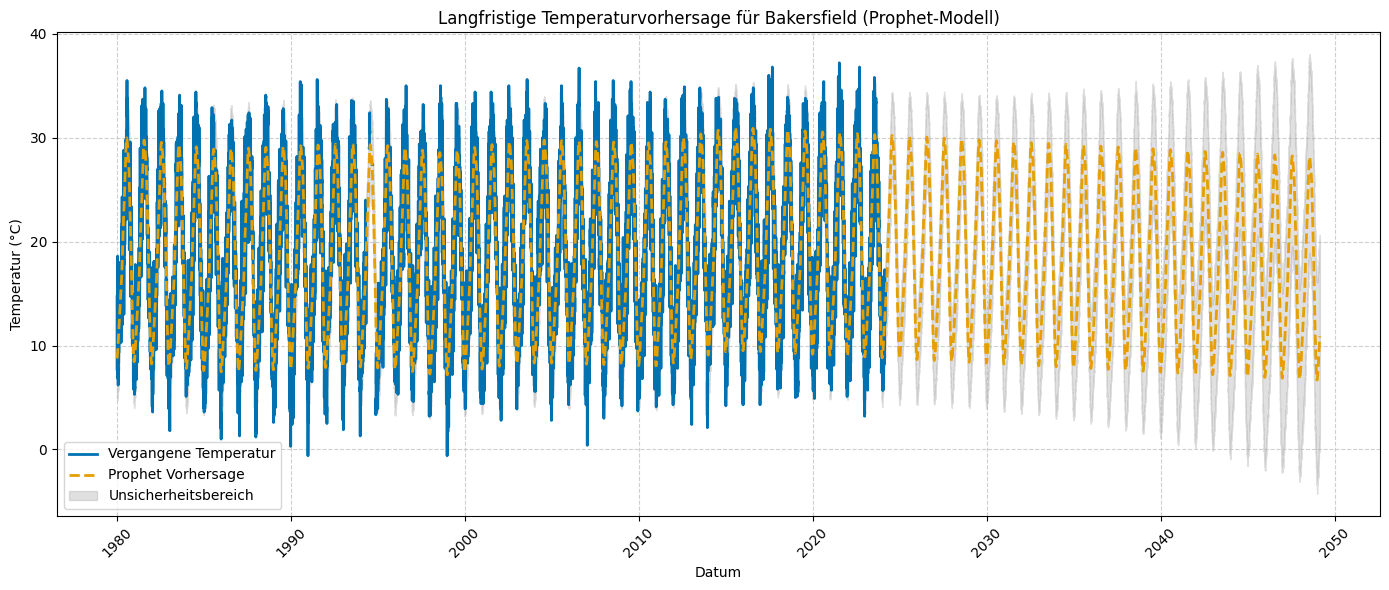

In [12]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
# data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=25*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

15:48:38 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing


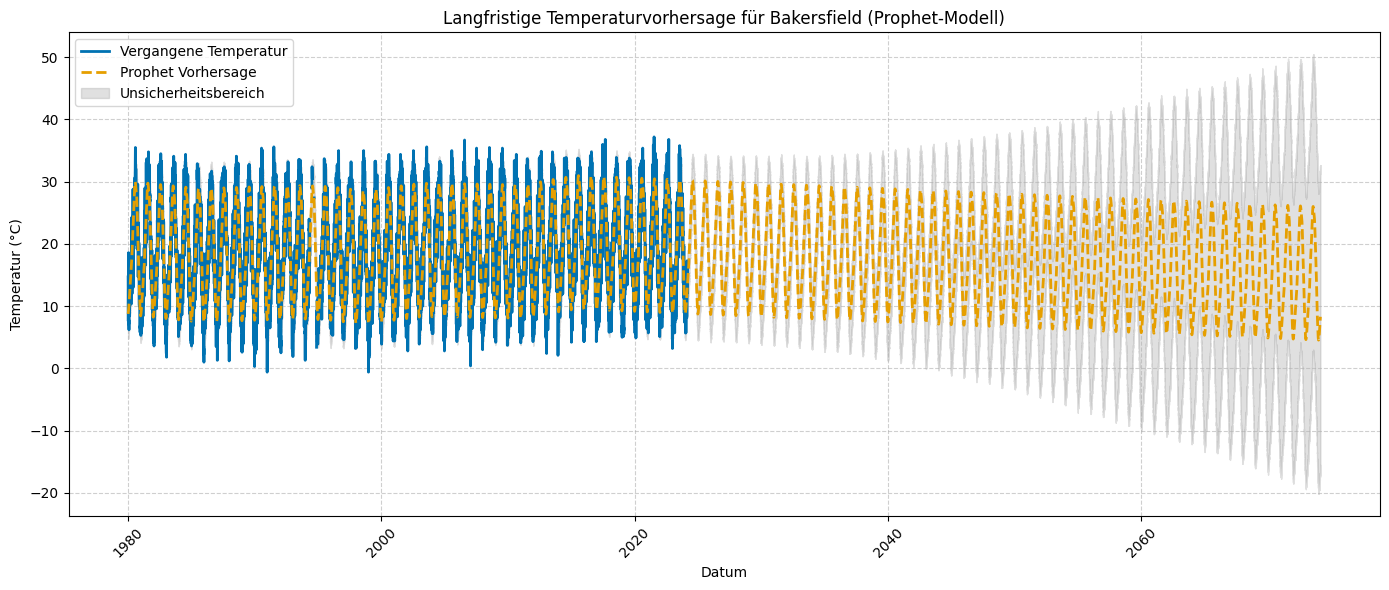

In [13]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
# data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=50*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 175


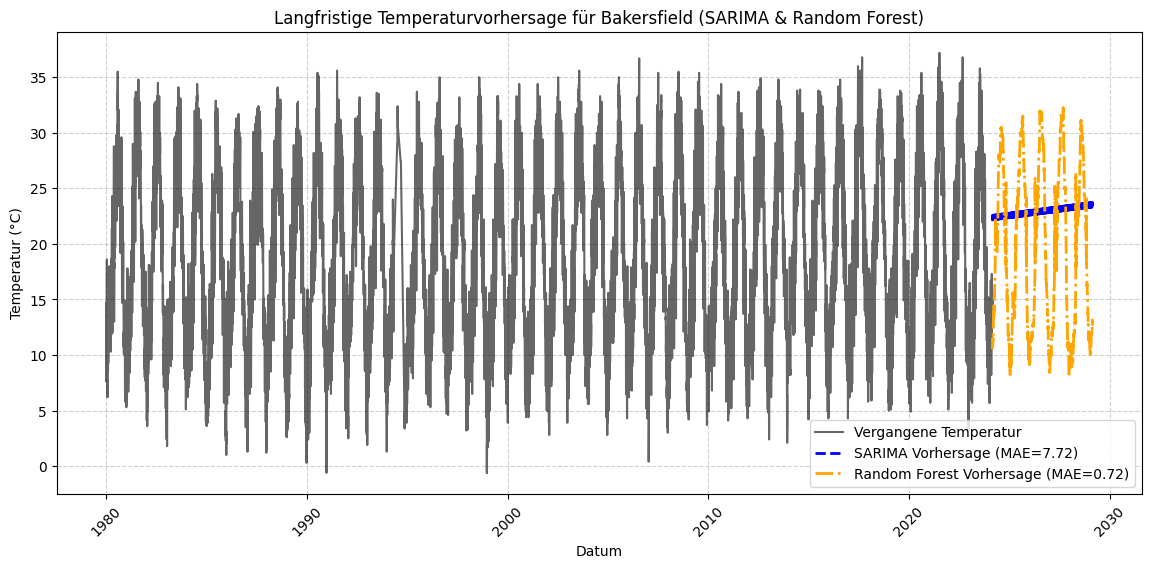

(count    16132.000000
 mean        18.814908
 std          7.883998
 min         -0.600000
 25%         12.200000
 50%         18.200000
 75%         25.800000
 max         37.200000
 Name: tavg, dtype: float64,
 7.716367748712959,
 0.7234406646193395)

In [14]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
# data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 5 Jahre
forecast_steps = 5 * 365  # 5 Jahre
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 175


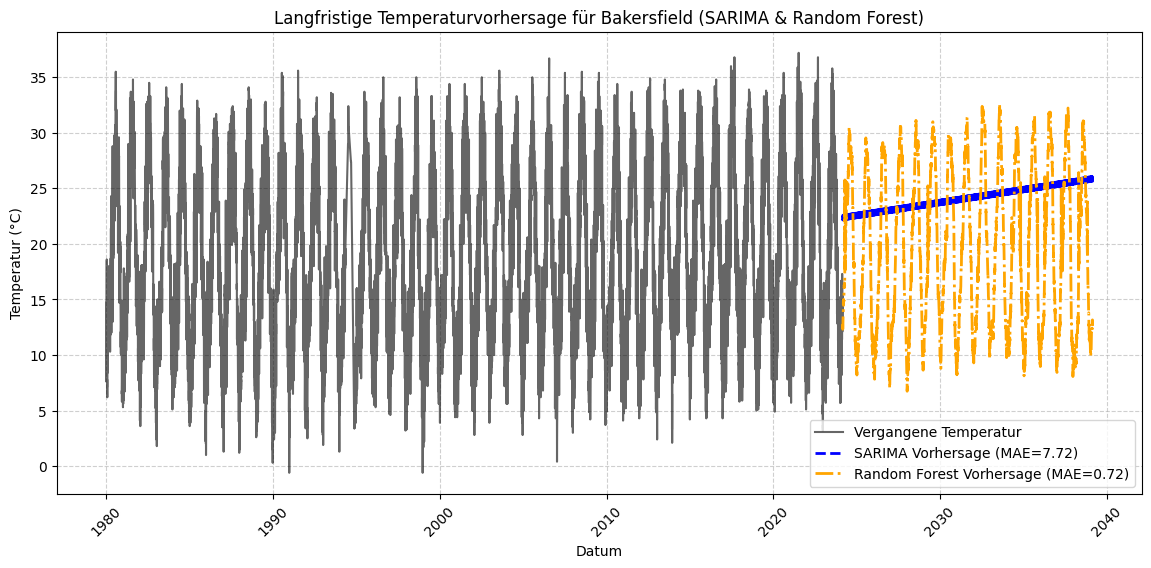

(count    16132.000000
 mean        18.814908
 std          7.883998
 min         -0.600000
 25%         12.200000
 50%         18.200000
 75%         25.800000
 max         37.200000
 Name: tavg, dtype: float64,
 7.716367748712959,
 0.7234406646193395)

In [15]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
# data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 15 Jahre
forecast_steps = 15 * 365
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

ADF-Test p-Wert: 0.0000
Zeitreihe ist stationär.


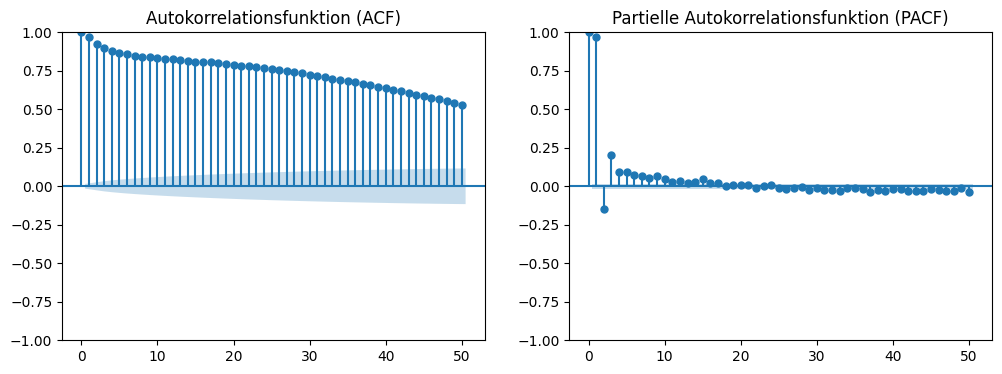

In [17]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')

# Stationaritätsprüfung mit ADF-Test
result = adfuller(data['tavg'])
print(f"ADF-Test p-Wert: {result[1]:.4f}")
if result[1] < 0.05:
    print("Zeitreihe ist stationär.")
    stationary_series = data['tavg']
else:
    print("Zeitreihe ist nicht stationär. Differenzierung wird angewendet.")
    stationary_series = data['tavg'].diff().dropna()


# Autokorrelationsfunktion (ACF) und partielle Autokorrelationsfunktion (PACF) plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['tavg'].dropna(), ax=axes[0], lags=50)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
plot_pacf(data['tavg'].dropna(), ax=axes[1], lags=50)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.show()

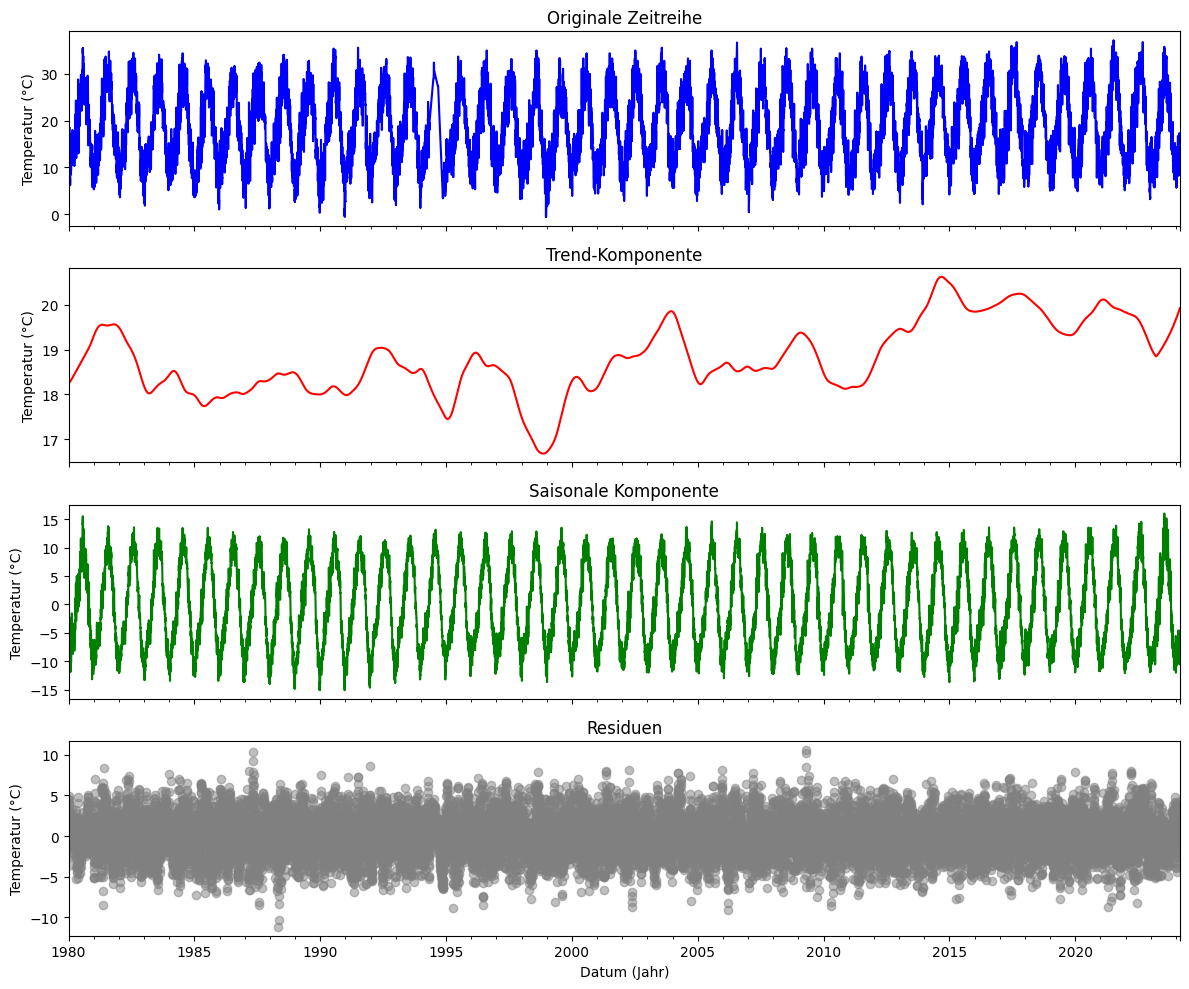

In [18]:
warnings.filterwarnings("ignore")

# Datum als Index setzen und sortieren
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')

# NaN-Werte entfernen (sicherstellen für STL)
data = data.dropna(subset=['tavg'])

# Saisonale Dekomposition durchführen
stl = STL(data['tavg'], period=365)
decomp = stl.fit()

# Ergebnisse visualisieren
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

data['tavg'].plot(ax=axes[0], title='Originale Zeitreihe', color='blue')
decomp.trend.plot(ax=axes[1], title='Trend-Komponente', color='red')
decomp.seasonal.plot(ax=axes[2], title='Saisonale Komponente', color='green')
axes[3].scatter(data.index, decomp.resid, color='gray', alpha=0.5)
axes[3].set_title('Residuen')

for ax in axes:
    ax.set_ylabel('Temperatur (°C)')
axes[-1].set_xlabel('Datum (Jahr)')

plt.tight_layout()
plt.show()


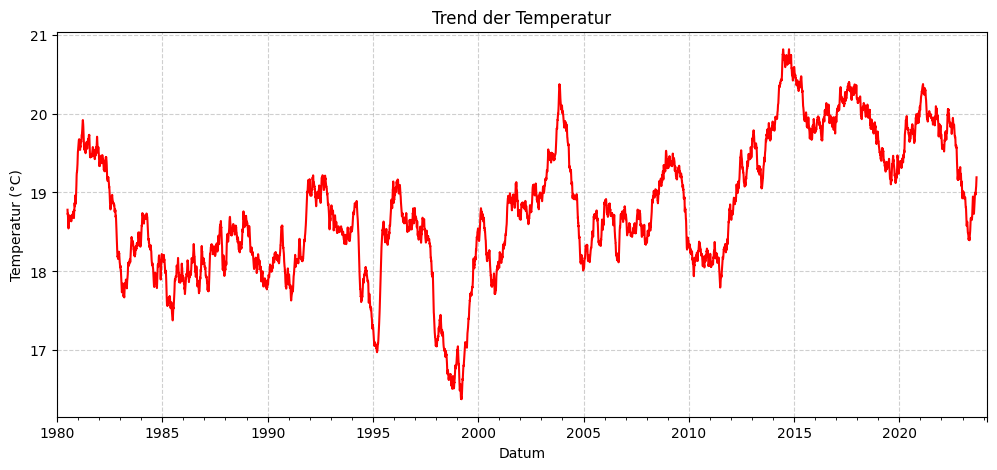

In [19]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')

# Saisonale Dekomposition durchführen
decomposed = seasonal_decompose(data['tavg'], model='additive', period=365)

# Nur den Trend plotten
plt.figure(figsize=(12, 5))
decomposed.trend.plot(title='Trend der Temperatur', color='red')
plt.xlabel('Datum')
plt.ylabel('Temperatur (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Extremwert Analyse

### Erster Ansatz
#### Block-Maxima-Methode

- Die Zeitreihe wird in gleich große Abschnitte („Blöcke“) unterteilt (z. B. Jahre, Monate, Tage).
- Pro Block wird nur das Maximum (oder Minimum) betrachtet.
- Die Verteilung dieser Block-Maxima wird durch die Generalized Extreme Value (GEV)-Verteilung modelliert.

Geschätzte GEV-Parameter:
  Shape (c = –ξ): 0.7451
  Location (μ):   33.83
  Scale (σ):      2.54


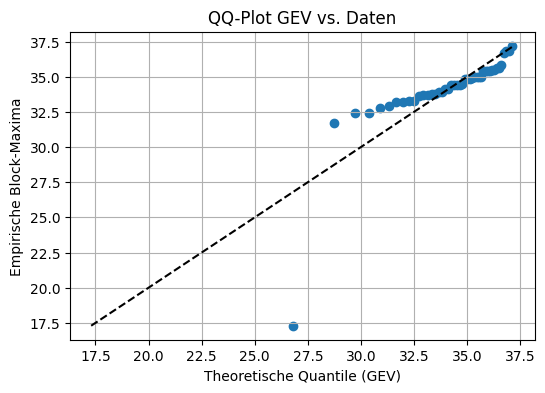

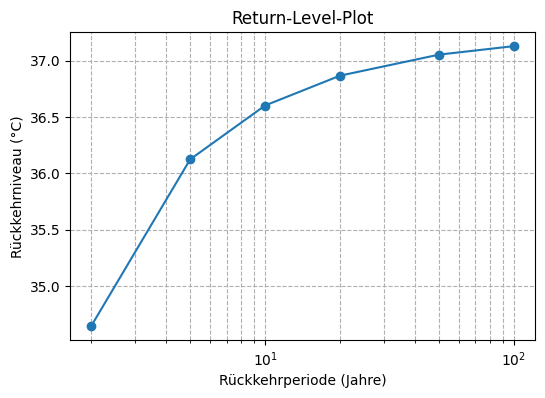

In [30]:
from scipy.stats import genextreme as gev, norm

# 1. Sicherstellen, dass der Index ein DatetimeIndex ist
data.index = pd.to_datetime(data.index)

# 2. Block-Maxima extrahieren (Jahresmaxima der tmax-Spalte)
#    'A' steht für Jahresende-Resampling
block_maxima = data['tavg'].resample('A').max().dropna()

# 3. GEV-Verteilung anpassen
#    Achtung: in scipy.stats.genextreme ist c = –ξ (Shape-Parameter)
c, loc, scale = gev.fit(block_maxima)

print("Geschätzte GEV-Parameter:")
print(f"  Shape (c = –ξ): {c:.4f}")
print(f"  Location (μ):   {loc:.2f}")
print(f"  Scale (σ):      {scale:.2f}")

# 4. QQ-Plot zur Modell-Diagnose
emp_q = np.sort(block_maxima.values)
prob = (np.arange(1, len(emp_q) + 1) - 0.5) / len(emp_q)
theo_q = gev.ppf(prob, c, loc=loc, scale=scale)

plt.figure(figsize=(6,4))
plt.scatter(theo_q, emp_q)
plt.plot([emp_q.min(), emp_q.max()],
         [emp_q.min(), emp_q.max()], 'k--')
plt.xlabel('Theoretische Quantile (GEV)')
plt.ylabel('Empirische Block-Maxima')
plt.title('QQ-Plot GEV vs. Daten')
plt.grid(True)
plt.show()

# 5. Return-Level-Plot für verschiedene Rückkehrperioden
return_periods = np.array([2, 5, 10, 20, 50, 100])  # in Jahren
prob_exceed = 1 - 1/return_periods
return_levels = gev.ppf(prob_exceed, c, loc=loc, scale=scale)

plt.figure(figsize=(6,4))
plt.plot(return_periods, return_levels, marker='o')
plt.xscale('log')
plt.xlabel('Rückkehrperiode (Jahre)')
plt.ylabel('Rückkehrniveau (°C)')
plt.title('Return-Level-Plot')
plt.grid(True, which="both", ls="--")
plt.show()

95%-CI für GEV-Parameter [shape, loc, scale]:
[[ 0.55422749 33.11219714  1.85128283]
 [ 1.06048216 34.67141896  3.2683398 ]]

95%-CI für Return Levels:
 2-Jahre: 34.00 – 35.39 °C
 5-Jahre: 35.59 – 36.56 °C
 10-Jahre: 36.14 – 36.87 °C
 20-Jahre: 36.44 – 37.03 °C
 50-Jahre: 36.61 – 37.14 °C
 100-Jahre: 36.68 – 37.19 °C

Mann–Kendall-Test auf Jahresmaxima: S=211.0, Z=2.06, p=0.040

Anzahl Hitze-Cluster: 321
GEV-Fit nach Declustering (c, loc, scale):
 -0.1909, 40.16, 0.88


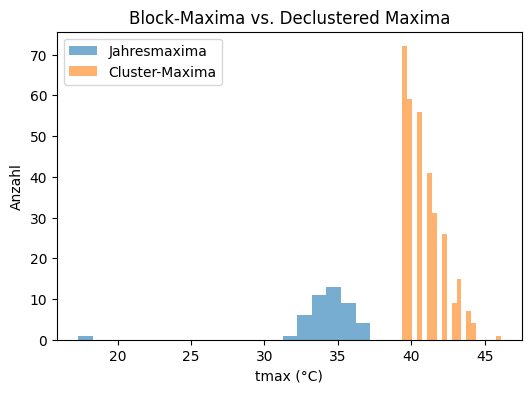

In [31]:
# 1) Parametrischer Bootstrap zur Unsicherheits-Abschätzung
n_boot = 500
params_bs = np.zeros((n_boot, 3))
return_periods = np.array([2, 5, 10, 20, 50, 100])
rl_bs = np.zeros((n_boot, len(return_periods)))

for i in range(n_boot):
    # Simuliere Block-Maxima nach deinem Modell
    sim = gev.rvs(c, loc=loc, scale=scale, size=len(block_maxima))
    # Fit auf die Simulation
    c_bs, loc_bs, scale_bs = gev.fit(sim)
    params_bs[i] = [c_bs, loc_bs, scale_bs]
    # Berechne Return Levels
    probs = 1 - 1/return_periods
    rl_bs[i] = gev.ppf(probs, c_bs, loc=loc_bs, scale=scale_bs)

# Konfidenzintervalle
ci_params = np.percentile(params_bs, [2.5, 97.5], axis=0)
ci_rl     = np.percentile(rl_bs, [2.5, 97.5], axis=0)

print("95%-CI für GEV-Parameter [shape, loc, scale]:")
print(ci_params)
print("\n95%-CI für Return Levels:")
for T, (lo, hi) in zip(return_periods, ci_rl.T):
    print(f" {T}-Jahre: {lo:.2f} – {hi:.2f} °C")

# 2) Mann–Kendall-Test zur Trend-Überprüfung in den Jahresmaxima
def mann_kendall(x):
    n = len(x)
    s = sum(np.sign(x[j] - x[i]) for i in range(n) for j in range(i+1, n))
    # Varianz berücksichtigen
    unique, counts = np.unique(x, return_counts=True)
    tie = counts[counts > 1]
    var_s = (n*(n-1)*(2*n+5) - sum(t*(t-1)*(2*t+5) for t in tie)) / 18
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    p = 2 * (1 - norm.cdf(abs(z)))
    return s, z, p

S, Z, p_value = mann_kendall(block_maxima.values)
print(f"\nMann–Kendall-Test auf Jahresmaxima: S={S}, Z={Z:.2f}, p={p_value:.3f}")

# 3) Declustering oberhalb eines Schwellenwertes (z.B. 95%-Quantil)
threshold = data['tmax'].quantile(0.95)
exceed = data['tmax'] > threshold
# Jeder neue Cluster, wenn exceed von False→True wechselt
cluster_id = (exceed & ~exceed.shift(1).fillna(False)).cumsum()
clusters = data[exceed].groupby(cluster_id)['tmax']
cluster_maxima = clusters.max()

print(f"\nAnzahl Hitze-Cluster: {cluster_maxima.size}")
c_d, loc_d, scale_d = gev.fit(cluster_maxima)
print("GEV-Fit nach Declustering (c, loc, scale):")
print(f" {c_d:.4f}, {loc_d:.2f}, {scale_d:.2f}")

# Optional: Histogramm-Vergleich
plt.figure(figsize=(6,4))
plt.hist(block_maxima, bins=20, alpha=0.6, label='Jahresmaxima')
plt.hist(cluster_maxima, bins=20, alpha=0.6, label='Cluster-Maxima')
plt.legend()
plt.title('Block-Maxima vs. Declustered Maxima')
plt.xlabel('tmax (°C)')
plt.ylabel('Anzahl')
plt.show()

# Auswertung der Extremwert-Analyse

## 1. Unsicherheitsabschätzung (Parametrischer Bootstrap)

- **95 %-Konfidenzintervalle GEV-Parameter**  
  - Shape (c): [0.55, 1.06]  
  - Location (μ): [33.11 °C, 34.67 °C]  
  - Scale (σ): [1.85 °C, 3.27 °C]  
- **95 %-Konfidenzintervalle Rückkehrniveaus**  
  | Rückkehrperiode | Unteres CI (°C) | Oberes CI (°C) |
  |-----------------|-----------------|----------------|
  | 2 Jahre         | 34.00           | 35.39          |
  | 5 Jahre         | 35.59           | 36.56          |
  | 10 Jahre        | 36.14           | 36.87          |
  | 20 Jahre        | 36.44           | 37.03          |
  | 50 Jahre        | 36.61           | 37.14          |
  | 100 Jahre       | 36.68           | 37.19          |

> **Interpretation:**  
> - Die Parameter-CIs zeigen, dass dein GEV-Fit verhältnismäßig stabil ist, aber mit zunehmender Rückkehrperiode werden die Unsicherheiten in den Rückkehrniveaus breiter.  
> - Besonders bei Rückkehrperioden > Datenlänge (hier ≈ 44 Jahre) steigen die Unsicherheiten deutlich.

---

## 2. Mann–Kendall-Trendtest auf Jahresmaxima

- **Teststatistiken:**  
  - \(S = 211.0\)  
  - \(Z = 2.06\)  
  - \(p = 0.040\)  

> **Schluss:**  
> Da \(p < 0.05\), liegt ein signifikanter **aufsteigender Trend** in den Jahresmaxima vor.  
> D. h. die jährlichen Höchsttemperaturen nehmen im untersuchten Zeitraum signifikant zu.

---

## 3. Declustering von Hitze-Ereignissen

- **Schwellenwert:** 95 %-Quantil von `tmax`  
- **Anzahl identifizierter Cluster:** 321  
- **GEV-Fit auf Cluster-Maxima:**  
  - Shape (c) = –0.1909  
  - Location (μ) = 40.16 °C  
  - Scale (σ) = 0.88 °C  

> **Bedeutung der negativen Shape (Weibull-Typ):**  
> - Die Verteilung der Cluster-Maxima hat einen **oberen Endpunkt**  
>   \[
>     x_\text{max} \approx μ - \frac{σ}{c} 
>     \approx 40.16 + \frac{0.88}{0.1909} \approx 44.8\;°C
>   \]
> - In der Realität wurden also keine Cluster-Maxima oberhalb von ~ 45 °C beobachtet.

---

## 4. Vergleich: Jahresmaxima vs. Declustered Maxima

![Block-Maxima vs. Declustered Maxima](/Users/arian/Documents/FHNW/spz/fs25/spz_mc/block-maxima-vs-declustered-maxima.png)

- **Jahresmaxima:**  
  - Werte liegen meist zwischen 31 °C und 38 °C.  
- **Cluster-Maxima:**  
  - Deutlich höhere Spitzen zwischen 39 °C und 47 °C.  
- **Schlussfolgerung:**  
  Die reine Block-Maxima-Betrachtung unterschätzt die tatsächlichen Spitzen einzelner Hitzewellen. Für Risikobewertungen (z. B. Infrastruktur-Planung, Gesundheitsvorsorge) sind die declusterten Maxima realistischer.

---

## 5. Empfehlungen und nächste Schritte

1. **Trend-GEV**: Bei nachgewiesenem Trend überlege, ein nicht-stationäres GEV-Modell zu verwenden (z. B. mit zeitabhängigen Parametern).  
2. **Weitere Unsicherheitsanalysen**:  
   - Nicht-parametrischer Bootstrap  
   - Bayessche Extremwertmodelle  
3. **Szenario-Analysen**: Analysiere verschiedene Schwellenwerte (z. B. 90 %, 99 %) und Blockgrößen (Monat vs. Jahr), um die Robustheit deiner Ergebnisse zu prüfen.  

---

*Mit diesen Ergebnissen hast du eine umfassende Basis, um Extremtemperaturen quantitativ zu bewerten, Unsicherheiten transparent zu kommunizieren und fundierte Risikoeinschätzungen zu erstellen.*```

#### Peaks-Over-Thershold (POT)-Methode
- Anstatt feste Zeitblöcke zu definieren, wählt man einen hohen Schwellenwert $u$.
- Alle Beobachtungen oberhalb von $u$ werden gesondert betrachtet („Peaks over Threshold“).
- Die Exzessverteilung $X - u, X > u$ folgt asymptotisch der Generalized Pareto (GP)-Verteilung.

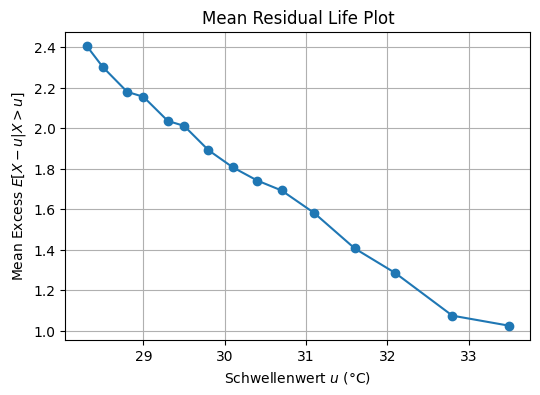

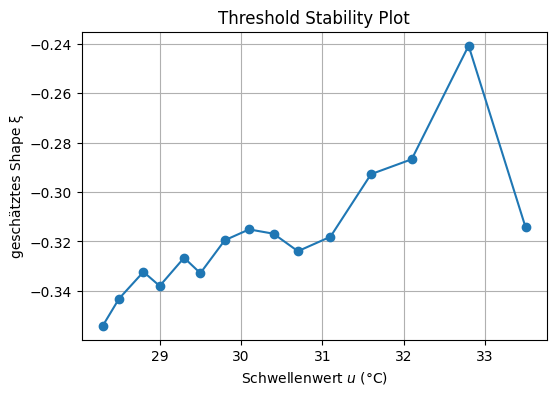

GPD-Parameter:  ξ=-0.3531,  scale=2.39  (loc=0)


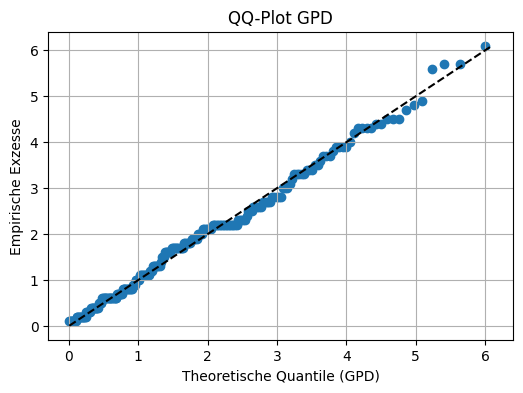

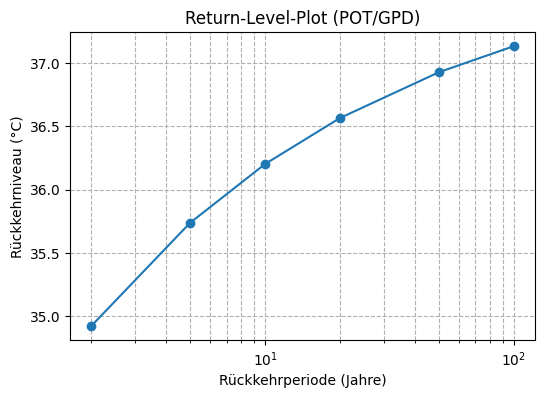

In [32]:
from scipy.stats import genpareto

t = data['tavg']

# ── 1) Mean Residual Life Plot (Schwellenwahl) ────────────────────────────────
qs = np.linspace(0.85, 0.99, 15)
u_vals = t.quantile(qs)
mean_exc = [(t[t>u] - u).mean() for u in u_vals]

plt.figure(figsize=(6,4))
plt.plot(u_vals, mean_exc, 'o-')
plt.xlabel('Schwellenwert $u$ (°C)')
plt.ylabel('Mean Excess $E[X-u|X>u]$')
plt.title('Mean Residual Life Plot')
plt.grid(True)
plt.show()

# ── 2) Threshold‐Stability Plot ───────────────────────────────────────────────
xis, sigmas = [], []
for u in u_vals:
    exc = t[t>u] - u
    c, loc, scale = genpareto.fit(exc, floc=0)
    xis.append(c)
    sigmas.append(scale)

plt.figure(figsize=(6,4))
plt.plot(u_vals, xis, 'o-')
plt.xlabel('Schwellenwert $u$ (°C)')
plt.ylabel('geschätztes Shape ξ')
plt.title('Threshold Stability Plot')
plt.grid(True)
plt.show()

# ── 3) Exzesse extrahieren & Declustering ────────────────────────────────────
u0 = t.quantile(0.95)     # wähle hier deinen Schwellenwert
exceed = t > u0
# Jeder neue Cluster beginnt, wenn exceed von False auf True wechselt
cluster_id = (exceed & ~exceed.shift(1).fillna(False)).cumsum()
# Cluster‐Maxima über dem Schwellenwert minus u0 = die Exzesse
exceedances = t[exceed].groupby(cluster_id).max() - u0

# ── 4) GPD-Fit auf die (declusterten) Exzesse ────────────────────────────────
c, loc, scale = genpareto.fit(exceedances, floc=0)
print(f"GPD-Parameter:  ξ={c:.4f},  scale={scale:.2f}  (loc={loc})")

# ── 5) QQ-Plot der Exzesse gegen GPD ─────────────────────────────────────────
emp = np.sort(exceedances.values)
prob = (np.arange(1,len(emp)+1) - 0.5) / len(emp)
theo = genpareto.ppf(prob, c, loc=0, scale=scale)

plt.figure(figsize=(6,4))
plt.scatter(theo, emp)
m = min(emp.min(), theo.min()); M = max(emp.max(), theo.max())
plt.plot([m,M],[m,M],'k--')
plt.xlabel('Theoretische Quantile (GPD)')
plt.ylabel('Empirische Exzesse')
plt.title('QQ-Plot GPD')
plt.grid(True)
plt.show()

# ── 6) Return-Level-Plot (Jahres-Rückkehrperioden) ──────────────────────────
# Jahresrate an Exzessen:
years = (data.index.max() - data.index.min()).days / 365.25
lambda_year = len(exceedances) / years

return_periods = np.array([2,5,10,20,50,100])  # in Jahren
# Formel: x_T = u0 + (σ/ξ)[ (λ_year·T)^ξ − 1 ]
rl = u0 + (scale / c) * ((lambda_year * return_periods)**c - 1)

plt.figure(figsize=(6,4))
plt.plot(return_periods, rl, 'o-')
plt.xscale('log')
plt.xlabel('Rückkehrperiode (Jahre)')
plt.ylabel('Rückkehrniveau (°C)')
plt.title('Return-Level-Plot (POT/GPD)')
plt.grid(True, which='both', ls='--')
plt.show()

# Interpretation der POT-Analyse (Peaks-Over-Threshold)

## 1. Mean Residual Life Plot  
![Mean Residual Life Plot](Mean_Residual_Life_Plot.png)  
- **Horizontaler Trend** in der Mean-Excess-Kurve deutet auf einen stabilen Schwellenbereich hin.  
- In deinem Plot fällt die Kurve mit steigendem \(u\) gleichmäßig ab, ohne starke Knickstellen – das spricht für einen Schwellenbereich etwa zwischen 30 °C und 32 °C.  
- **Wahl des Schwellenwerts**: Man wählt \(u\) in diesem Bereich, um genügend Exzesse zu haben, ohne zu weit in den Körper der Verteilung zu gehen.

---

## 2. Threshold Stability Plot  
![Threshold Stability Plot](Threshold_Stability_Plot.png)  
- Zeigt den geschätzten Shape-Parameter \(\xi\) gegen verschiedene Schwellen \(u\).  
- Ein **flacher Bereich** (konstantes \(\xi\)) signalisiert, dass das GPD-Modell robust gegen die Wahl von \(u\) ist.  
- In deinem Plot liegt \(\xi\) bei \(u\approx30\) bis 32 °C relativ stabil um \(-0.30\).  
- **Empfehlung**: Wähle \(u\) in diesem stabilen Intervall (z. B. 31 °C), um Verzerrungen zu minimieren.

---

## 3. QQ-Plot der Exzesse gegen GPD  
![QQ-Plot GPD](QQ-Plot_GPD.png)  
- Vergleicht empirische Exzesse \((X - u)\) mit den theoretischen Quantilen der Generalized Pareto (GPD).  
- Punkte nahe der Diagonalen → sehr gute Modellanpassung.  
- Dein Plot zeigt nahezu perfekte Übereinstimmung, auch im oberen Bereich – das GPD-Modell ist gut geeignet.

---

## 4. Return-Level-Plot (POT/GPD)  
![Return-Level-Plot (POT/GPD)](Return_Level_Plot_POT.png)  
- Stellt für Rückkehrperioden \(T\) in Jahren das Niveau \(x_T\) dar, das im Mittel einmal alle \(T\) Jahre überschritten wird.  
- Deine Kurve verläuft sanft ansteigend von etwa 34.9 °C (2-Jahres-Event) bis 37.1 °C (100-Jahres-Event).  
- **Log-Skala** auf der x-Achse verdeutlicht, dass Unsicherheit bei größeren \(T\) zunimmt und die Kurve abflacht.  
- Vergleich mit Block-Maxima-Plot: Die Rückkehrniveaus sind sehr ähnlich, bestätigen also deine früheren Ergebnisse.

---

**Fazit:**  
Die POT-Analyse liefert konsistente Parameter (\(\xi\approx-0.30\), \(\sigma\) je nach Fit) und Rückkehrniveaus, validiert durch stabile Mean-Residual-Life- und Threshold-Stability-Plots sowie einen nahezu perfekten QQ-Plot. Die Rückkehrlevel-Kurve ergänzt deine Block-Maxima-Ergebnisse und unterstützt deine Risikoabschätzung extremer Höchsttemperaturen.```